In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase.io as aio
import numpy as np
import numba
import pandas as pd
from scipy.spatial import cKDTree
from toolz.curried import pipe, curry, compose
import atomstat.atom_stat as astat

In [3]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
def draw(im):
    im1 = np.squeeze(im)
    plt.imshow(im1)
    plt.colorbar()
    plt.grid(False)
    plt.show()

## Estimate Distrubance in 3D

In our use of both two point statistics and rdf, we first extract atoms that constitute the substructure of interest (e.g. cascade or grain boundary) - then utilize either of these two metrics to aggregate the local environment around all the atoms constituting the substructure.

* Load coordinates of all atoms in 'coords_all'
* Load coordinates of disturbed atom in 'coords_sub' 
    * (They can be computed using ovito - Common Neighbour Analysis and saved in an xyz file )
* The xyz file if available can be read with ase usin the following code snippet:

         atom = aio.read("file_name.xyz")
         coords = atom.get_positions()



In [6]:
loader = compose(lambda x: np.asarray(x.iloc[:,2:5]), 
                 lambda x: pd.read_table(x, delimiter=" ", skiprows=9, header=None))

### When computing for perfect structures, I am randomly choosing 100 atoms for which I will compute the Two Point Statistics

In [56]:
# fname = "../data/data-1-20kev-analysis/data-new/dump.Si_Perfect_Quenched"
fname = "../new-data/CK_Cu_ACC_DUMP/dump.arc.0"
coords_all = loader(fname)
ind = np.random.randint(0, coords_all.shape[0], 1000)
coords_sub = coords_all[ind]

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [11]:
# run = 1
# fname = "../data/data-1-20kev-analysis/data-new/dump.Quench_Damaged.10000_Run-{}".format(run)
# coords_all = loader(fname)
# atom = aio.read("../data/data-1-20kev-analysis/coords/data_{}_new.xyz".format(run))
# coords_sub = atom.get_positions()

In [30]:
center = (coords_all.max(axis=0) + coords_all.min(axis=0))/2

In [31]:
cell = coords_all.max(axis=0) - coords_all.min(axis=0)

In [58]:
pbc = [1,1,1]
cell = np.asarray([[1,0,0],[0,1,0],[0,0,1]]) * 362.95
coords_min = coords_all.min(axis=0)
coords_ref = coords_all - coords_min

In [59]:
n_atoms = len(coords_ref)

for indx

In [42]:
def get_voxelizedStats(coords1, coords2=None, 
                       r_stat=5.0, 
                       len_pixel=10, 
                       cell=[[1,0,0],[0,1,0],[0,0,1]], 
                       pbc=[1,1,1]):

    center = cell.sum(axis=0)*0.5

    if coords2 is None:
        coords2 = coords1.copy()

    n_atoms1 = coords1.shape[0]
    n_atoms2 = coords2.shape[0]

    stat_coords = np.zeros([n_atoms1 * n_atoms2, 3])

    for indx, coord in enumerate(coords1):
        shift = center - coord
        stat_coords[indx * n_atoms2:(indx+1) * n_atoms2,:] = coords2 + shift

    indexes = pipe(stat_coords,
                   astat.get_scaled_positions(cell=cell, pbc=pbc),
                   astat.get_real_positions(cell=cell),
                   lambda x: x - center + r_stat,
                   lambda x: (np.round(x * len_pixel)).astype(int))

    shape = [int(r_stat * 2 * len_pixel + 1)] * 3

    box = pipe(shape,
               lambda shape: np.zeros(shape),
               lambda box: astat.box_count(box, indexes, indexes.shape[0], shape),
               lambda box: box / n_atoms1)
    return box

In [51]:
%%time
box = get_voxelizedStats(coords_sub-coords_min, 
                         coords_sub-coords_min, r_stat=5.0, len_pixel=10, cell=cell, pbc=pbc)

CPU times: user 1.04 s, sys: 42.7 ms, total: 1.09 s
Wall time: 179 ms


### Compute the vector counts and save them in a matrix called box

In [26]:
r_stat = 8 # radius of the statistics
len_pixel = 10 # voxel size

In [27]:
%%time
box = astat.get_voxelizedStats_tree(coords_all, coords_sub, r_stat, len_pixel)

CPU times: user 30.1 s, sys: 6.48 s, total: 36.5 s
Wall time: 41.8 s


### Visualize the vector counts

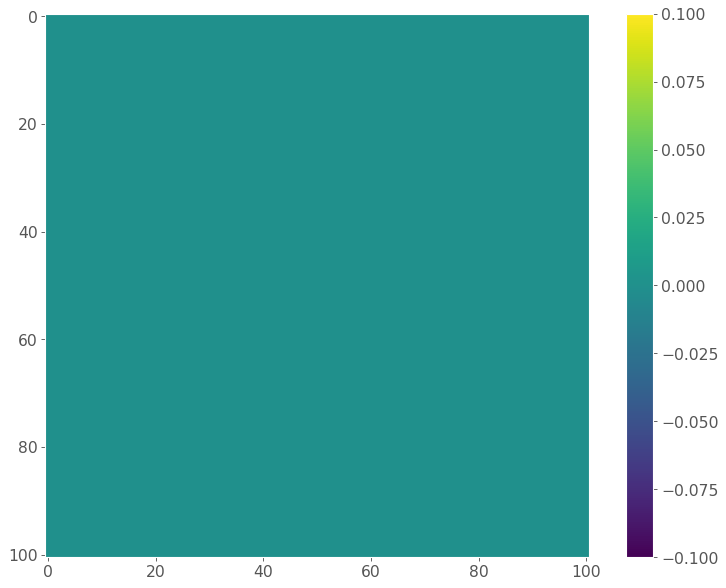

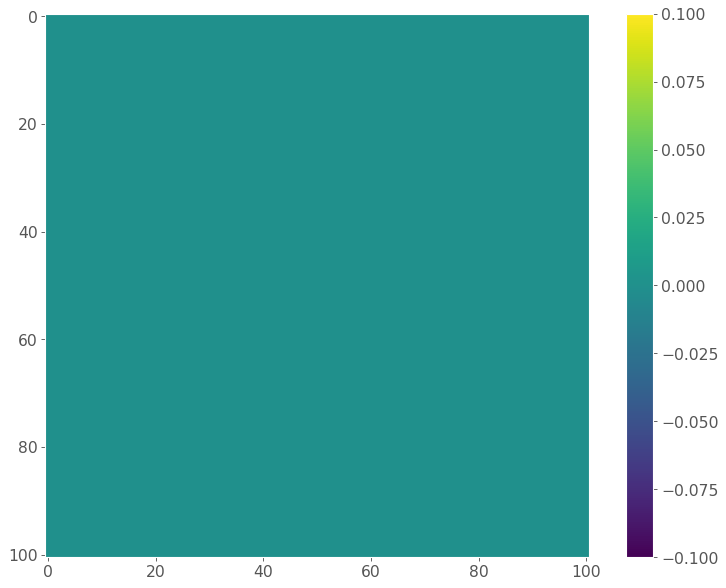

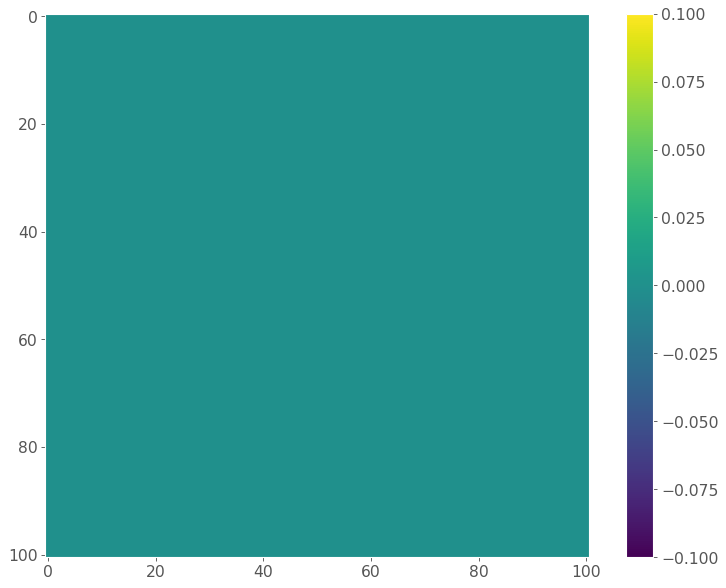

In [52]:
idx = int(r_stat * len_pixel)
draw(box[:,:, idx])
draw(box[:, idx, :])
draw(box[idx,:,:])

### Compute a smoothening filter for two point statistics

In [53]:
r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray(box.shape) + int(2 * r_s * len_pixel)

In [54]:
fs = pipe(r_s, 
          lambda r_s: astat.sphere(r_s * len_pixel),
          lambda s: astat.padder(s, new_shape), 
          lambda s: astat.imfilter(s, f_data=s) / np.count_nonzero(s))

### Visualize the smoothening filter

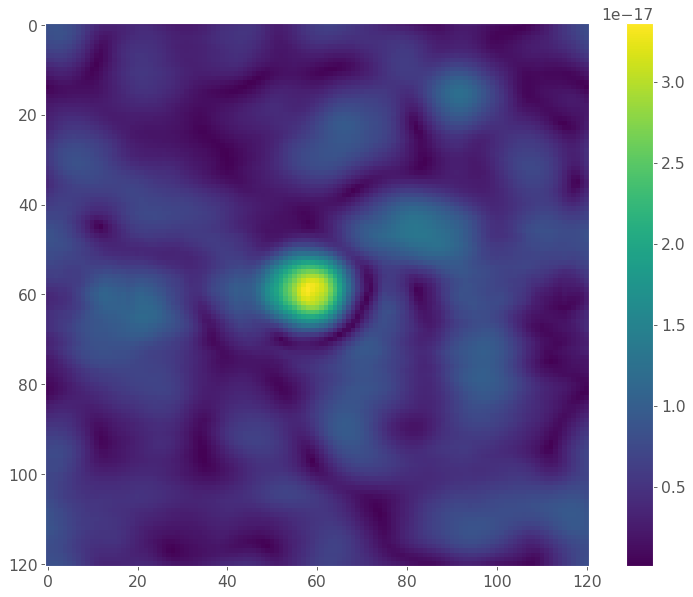

In [55]:
idx = int((r_stat + r_s) * len_pixel)
draw((fs[:,:, idx]))

## Apply the smoothening filter to the box

In [49]:
%%time
box1 = pipe(box, 
            lambda s: astat.padder(s, new_shape), 
            lambda s: astat.imfilter(s, f_data=fs))

CPU times: user 242 ms, sys: 56.4 ms, total: 298 ms
Wall time: 298 ms


In [20]:
box1.shape

(181, 181, 181)

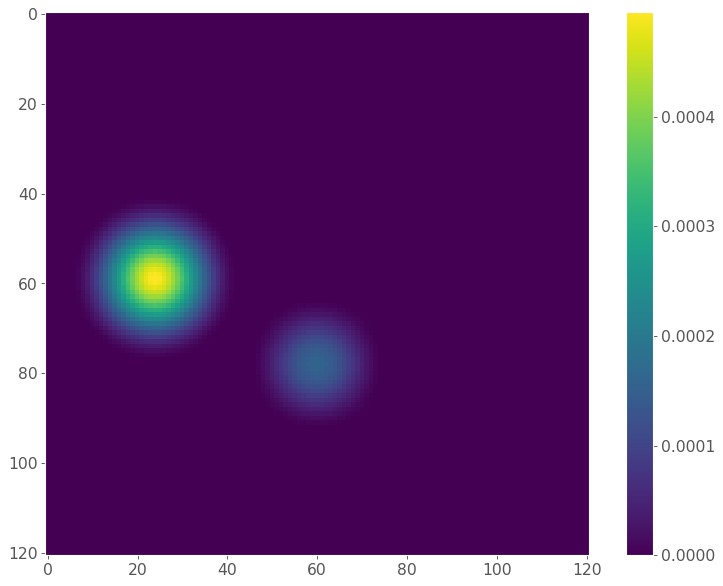

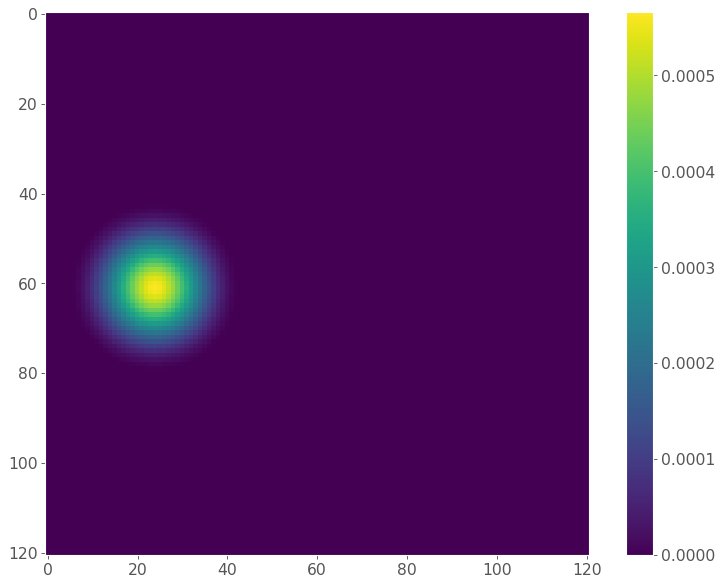

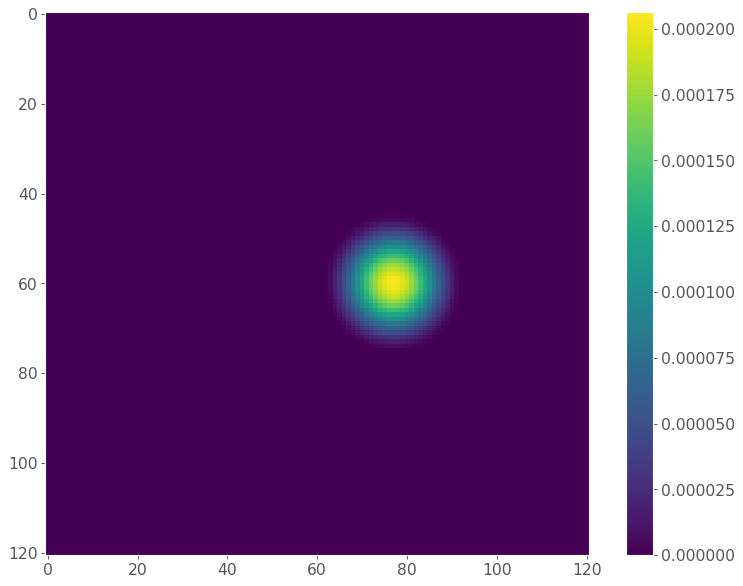

In [50]:
idx = int((r_stat + r_s) * len_pixel)
draw(box1[:,:, idx])
draw(box1[:, idx, :])
draw(box1[idx,:,:])